In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, chi2_contingency, fisher_exact
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

In [2]:
# Identify project's root directory
project_path = os.path.dirname(os.getcwd())

# Data import: read clinical data as pandas dataframe
pxa_path = os.path.join(project_path, 'data' ,'pxa_data.csv')
pxa = pd.read_csv(pxa_path)
pxa.set_index('ID', inplace=True)

In [3]:
# Create the two groups based on the "tumor-epilepsy" column
pxa_initial_sz = pxa[pxa['first_tumor_sz'] == 1]
pxa_initial_other = pxa[pxa['first_tumor_sz'] == 0]
pxa_tre = pxa[pxa['tumor_epilepsy'] == 1]
pxa_no_tre = pxa[pxa['tumor_epilepsy'] == 0]

## Table 1: Clinical characteristics of seizures vs. no seizures

### Totals

In [4]:
# Calculate the total number of patients in each group
total_initial_sz = len(pxa_initial_sz)
total_initial_other = len(pxa_initial_other)
total_tre = len(pxa_tre)
total_no_tre = len(pxa_no_tre)

# Calculate the total number of patients
total_patients = total_initial_sz + total_initial_other

# Calculate the proportion of total for each group
prop_initial_sz = total_initial_sz / total_patients
prop_initial_other = total_initial_other / total_patients
prop_tre = total_tre / total_patients
prop_no_tre = total_no_tre / total_patients

print(f"Total number of patients in pxa_initial_sz: {total_initial_sz}")
print(f"Proportion of total patients in pxa_initial_sz: {prop_initial_sz:.2f}")

print(f"Total number of patients in pxa_initial_other: {total_initial_other}")
print(f"Proportion of total patients in pxa_initial_other: {prop_initial_other:.2f}")

print(f"Total number of patients in pxa_tre: {total_tre}")
print(f"Proportion of total patients in pxa_tre: {prop_tre:.2f}")

print(f"Total number of patients in pxa_no_tre: {total_no_tre}")
print(f"Proportion of total patients in pxa_no_tre: {prop_no_tre:.2f}")

Total number of patients in pxa_initial_sz: 25
Proportion of total patients in pxa_initial_sz: 0.71
Total number of patients in pxa_initial_other: 10
Proportion of total patients in pxa_initial_other: 0.29
Total number of patients in pxa_tre: 27
Proportion of total patients in pxa_tre: 0.77
Total number of patients in pxa_no_tre: 8
Proportion of total patients in pxa_no_tre: 0.23


### Continuous data: age of onset, tumor size

In [5]:
# Calculate the median age and range for each group
def calculate_median_and_range(df, column):
    median = df[column].median()
    min_val = df[column].min()
    max_val = df[column].max()
    return median, min_val, max_val

median_age_initial_sz, min_age_initial_sz, max_age_initial_sz = calculate_median_and_range(pxa_initial_sz, 'presentation_1_age')
median_age_initial_other, min_age_initial_other, max_age_initial_other = calculate_median_and_range(pxa_initial_other, 'presentation_1_age')
median_age_tre, min_age_tre, max_age_tre = calculate_median_and_range(pxa_tre, 'presentation_1_age')
median_age_no_tre, min_age_no_tre, max_age_no_tre = calculate_median_and_range(pxa_no_tre, 'presentation_1_age')

print(f"Median age of initial presentation in pxa_initial_sz: {median_age_initial_sz}")
print(f"Range of age of initial presentation in pxa_initial_sz: {min_age_initial_sz} - {max_age_initial_sz}")

print(f"Median age of initial presentation in pxa_initial_other: {median_age_initial_other}")
print(f"Range of age of initial presentation in pxa_initial_other: {min_age_initial_other} - {max_age_initial_other}")

print(f"Median age of initial presentation in pxa_tre: {median_age_tre}")
print(f"Range of age of initial presentation in pxa_tre: {min_age_tre} - {max_age_tre}")

print(f"Median age of initial presentation in pxa_no_tre: {median_age_no_tre}")
print(f"Range of age of initial presentation in pxa_no_tre: {min_age_no_tre} - {max_age_no_tre}")

# Check for normality using the Shapiro-Wilk test
def check_normality(df, column):
    return shapiro(df[column])

shapiro_sz = check_normality(pxa_initial_sz, 'presentation_1_age')
shapiro_other = check_normality(pxa_initial_other, 'presentation_1_age')
shapiro_tre = check_normality(pxa_tre, 'presentation_1_age')
shapiro_no_tre = check_normality(pxa_no_tre, 'presentation_1_age')

print(f"Shapiro-Wilk test for pxa_initial_sz: {shapiro_sz}")
print(f"Shapiro-Wilk test for pxa_initial_other: {shapiro_other}")
print(f"Shapiro-Wilk test for pxa_tre: {shapiro_tre}")
print(f"Shapiro-Wilk test for pxa_no_tre: {shapiro_no_tre}")

# Perform the appropriate test based on normality
def perform_statistical_test(df1, df2, column):
    shapiro1 = check_normality(df1, column)
    shapiro2 = check_normality(df2, column)
    if shapiro1.pvalue > 0.05 and shapiro2.pvalue > 0.05:
        t_statistic, p_value = ttest_ind(df1[column], df2[column])
        test_used = "t-test"
    else:
        u_statistic, p_value = mannwhitneyu(df1[column], df2[column])
        test_used = "Mann-Whitney U test"
    return test_used, t_statistic if test_used == "t-test" else u_statistic, p_value

test_used_age, statistic_age, p_value_age = perform_statistical_test(pxa_initial_sz, pxa_initial_other, 'presentation_1_age')
print(f"{test_used_age} for age of initial presentation: statistic={statistic_age}, p-value={p_value_age}")

test_used_age_tre, statistic_age_tre, p_value_age_tre = perform_statistical_test(pxa_tre, pxa_no_tre, 'presentation_1_age')
print(f"{test_used_age_tre} for age of initial presentation: statistic={statistic_age_tre}, p-value={p_value_age_tre}")

# Ensure tumor_size is numeric, converting non-numeric values to NaN and then dropping them
def filter_numeric(df, column):
    df_filtered = df.copy()
    df_filtered[column] = pd.to_numeric(df_filtered[column], errors='coerce')
    return df_filtered.dropna(subset=[column])

# Filter and analyze tumor_size
pxa_initial_sz_filtered = filter_numeric(pxa_initial_sz, 'tumor_size')
pxa_initial_other_filtered = filter_numeric(pxa_initial_other, 'tumor_size')
pxa_tre_filtered = filter_numeric(pxa_tre, 'tumor_size')
pxa_no_tre_filtered = filter_numeric(pxa_no_tre, 'tumor_size')

# Calculate the mean tumor size and standard deviation for each group
def calculate_mean_and_std(df, column):
    mean = df[column].mean()
    std = df[column].std()
    return mean, std

mean_tumor_size_initial_sz, std_tumor_size_initial_sz = calculate_mean_and_std(pxa_initial_sz_filtered, 'tumor_size')
mean_tumor_size_initial_other, std_tumor_size_initial_other = calculate_mean_and_std(pxa_initial_other_filtered, 'tumor_size')
mean_tumor_size_tre, std_tumor_size_tre = calculate_mean_and_std(pxa_tre_filtered, 'tumor_size')
mean_tumor_size_no_tre, std_tumor_size_no_tre = calculate_mean_and_std(pxa_no_tre_filtered, 'tumor_size')

print(f"Mean tumor size in pxa_initial_sz: {mean_tumor_size_initial_sz}")
print(f"Standard deviation of tumor size in pxa_initial_sz: {std_tumor_size_initial_sz}")

print(f"Mean tumor size in pxa_initial_other: {mean_tumor_size_initial_other}")
print(f"Standard deviation of tumor size in pxa_initial_other: {std_tumor_size_initial_other}")

print(f"Mean tumor size in pxa_tre: {mean_tumor_size_tre}")
print(f"Standard deviation of tumor size in pxa_tre: {std_tumor_size_tre}")

print(f"Mean tumor size in pxa_no_tre: {mean_tumor_size_no_tre}")
print(f"Standard deviation of tumor size in pxa_no_tre: {std_tumor_size_no_tre}")

# Check for normality using the Shapiro-Wilk test
shapiro_tumor_size_sz = check_normality(pxa_initial_sz_filtered, 'tumor_size')
shapiro_tumor_size_other = check_normality(pxa_initial_other_filtered, 'tumor_size')
shapiro_tumor_size_tre = check_normality(pxa_tre_filtered, 'tumor_size')
shapiro_tumor_size_no_tre = check_normality(pxa_no_tre_filtered, 'tumor_size')

print(f"Shapiro-Wilk test for tumor size in pxa_initial_sz: {shapiro_tumor_size_sz}")
print(f"Shapiro-Wilk test for tumor size in pxa_initial_other: {shapiro_tumor_size_other}")
print(f"Shapiro-Wilk test for tumor size in pxa_tre: {shapiro_tumor_size_tre}")
print(f"Shapiro-Wilk test for tumor size in pxa_no_tre: {shapiro_tumor_size_no_tre}")

# Perform the appropriate test based on normality
test_used_tumor_size, statistic_tumor_size, p_value_tumor_size = perform_statistical_test(pxa_initial_sz_filtered, pxa_initial_other_filtered, 'tumor_size')
print(f"{test_used_tumor_size} for tumor size: statistic={statistic_tumor_size}, p-value={p_value_tumor_size}")

test_used_tumor_size_tre, statistic_tumor_size_tre, p_value_tumor_size_tre = perform_statistical_test(pxa_tre_filtered, pxa_no_tre_filtered, 'tumor_size')
print(f"{test_used_tumor_size_tre} for tumor size: statistic={statistic_tumor_size_tre}, p-value={p_value_tumor_size_tre}")

# Ensure tumor_mutational_burden is numeric, converting non-numeric values to NaN and then dropping them
pxa_initial_sz_filtered = filter_numeric(pxa_initial_sz, 'tumor_mutational_burden')
pxa_initial_other_filtered = filter_numeric(pxa_initial_other, 'tumor_mutational_burden')
pxa_tre_filtered = filter_numeric(pxa_tre, 'tumor_mutational_burden')
pxa_no_tre_filtered = filter_numeric(pxa_no_tre, 'tumor_mutational_burden')

# Calculate the mean tumor mutational burden and standard deviation for each group
mean_tumor_mutational_burden_initial_sz, std_tumor_mutational_burden_initial_sz = calculate_mean_and_std(pxa_initial_sz_filtered, 'tumor_mutational_burden')
mean_tumor_mutational_burden_initial_other, std_tumor_mutational_burden_initial_other = calculate_mean_and_std(pxa_initial_other_filtered, 'tumor_mutational_burden')
mean_tumor_mutational_burden_tre, std_tumor_mutational_burden_tre = calculate_mean_and_std(pxa_tre_filtered, 'tumor_mutational_burden')
mean_tumor_mutational_burden_no_tre, std_tumor_mutational_burden_no_tre = calculate_mean_and_std(pxa_no_tre_filtered, 'tumor_mutational_burden')

print(f"Mean tumor mutational burden in pxa_initial_sz: {mean_tumor_mutational_burden_initial_sz}")
print(f"Standard deviation of tumor mutational burden in pxa_initial_sz: {std_tumor_mutational_burden_initial_sz}")

print(f"Mean tumor mutational burden in pxa_initial_other: {mean_tumor_mutational_burden_initial_other}")
print(f"Standard deviation of tumor mutational burden in pxa_initial_other: {std_tumor_mutational_burden_initial_other}")

print(f"Mean tumor mutational burden in pxa_tre: {mean_tumor_mutational_burden_tre}")
print(f"Standard deviation of tumor mutational burden in pxa_tre: {std_tumor_mutational_burden_tre}")

print(f"Mean tumor mutational burden in pxa_no_tre: {mean_tumor_mutational_burden_no_tre}")
print(f"Standard deviation of tumor mutational burden in pxa_no_tre: {std_tumor_mutational_burden_no_tre}")

# Check for normality using the Shapiro-Wilk test
shapiro_tumor_mutational_burden_sz = check_normality(pxa_initial_sz_filtered, 'tumor_mutational_burden')
shapiro_tumor_mutational_burden_other = check_normality(pxa_initial_other_filtered, 'tumor_mutational_burden')
shapiro_tumor_mutational_burden_tre = check_normality(pxa_tre_filtered, 'tumor_mutational_burden')
shapiro_tumor_mutational_burden_no_tre = check_normality(pxa_no_tre_filtered, 'tumor_mutational_burden')

print(f"Shapiro-Wilk test for tumor mutational burden in pxa_initial_sz: {shapiro_tumor_mutational_burden_sz}")
print(f"Shapiro-Wilk test for tumor mutational burden in pxa_initial_other: {shapiro_tumor_mutational_burden_other}")
print(f"Shapiro-Wilk test for tumor mutational burden in pxa_tre: {shapiro_tumor_mutational_burden_tre}")
print(f"Shapiro-Wilk test for tumor mutational burden in pxa_no_tre: {shapiro_tumor_mutational_burden_no_tre}")

# Perform the appropriate test based on normality
test_used_tumor_mutational_burden, statistic_tumor_mutational_burden, p_value_tumor_mutational_burden = perform_statistical_test(pxa_initial_sz_filtered, pxa_initial_other_filtered, 'tumor_mutational_burden')
print(f"{test_used_tumor_mutational_burden} for tumor mutational burden: statistic={statistic_tumor_mutational_burden}, p-value={p_value_tumor_mutational_burden}")

test_used_tumor_mutational_burden_tre, statistic_tumor_mutational_burden_tre, p_value_tumor_mutational_burden_tre = perform_statistical_test(pxa_tre_filtered, pxa_no_tre_filtered, 'tumor_mutational_burden')
print(f"{test_used_tumor_mutational_burden_tre} for tumor mutational burden: statistic={statistic_tumor_mutational_burden_tre}, p-value={p_value_tumor_mutational_burden_tre}")

Median age of initial presentation in pxa_initial_sz: 21.0
Range of age of initial presentation in pxa_initial_sz: 1 - 44
Median age of initial presentation in pxa_initial_other: 27.5
Range of age of initial presentation in pxa_initial_other: 17 - 50
Median age of initial presentation in pxa_tre: 21.0
Range of age of initial presentation in pxa_tre: 1 - 50
Median age of initial presentation in pxa_no_tre: 23.5
Range of age of initial presentation in pxa_no_tre: 17 - 37
Shapiro-Wilk test for pxa_initial_sz: ShapiroResult(statistic=0.9614605839251618, pvalue=0.4443273424053121)
Shapiro-Wilk test for pxa_initial_other: ShapiroResult(statistic=0.9131722454335094, pvalue=0.30349949661378445)
Shapiro-Wilk test for pxa_tre: ShapiroResult(statistic=0.963892431084562, pvalue=0.4512085635830397)
Shapiro-Wilk test for pxa_no_tre: ShapiroResult(statistic=0.8748435864469997, pvalue=0.16800325922697204)
t-test for age of initial presentation: statistic=-1.8757423118356389, p-value=0.0695606601186479

### Categorical data: female/male, tumor grade, tumor laterality

In [6]:
def perform_test(group1, group2, column_name):
    # Ensure the column is numeric, converting non-numeric values to NaN and then dropping them
    group1_filtered = group1.copy()
    group1_filtered[column_name] = pd.to_numeric(group1_filtered[column_name], errors='coerce')
    group1_filtered = group1_filtered.dropna(subset=[column_name])

    group2_filtered = group2.copy()
    group2_filtered[column_name] = pd.to_numeric(group2_filtered[column_name], errors='coerce')
    group2_filtered = group2_filtered.dropna(subset=[column_name])

    # Calculate the total numbers of 1s and 0s in each group
    total_1_group1 = (group1_filtered[column_name] == 1).sum()
    total_0_group1 = (group1_filtered[column_name] == 0).sum()

    total_1_group2 = (group2_filtered[column_name] == 1).sum()
    total_0_group2 = (group2_filtered[column_name] == 0).sum()

    # Calculate the proportions
    proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
    proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

    print(f"Total number of 1s in {column_name} for group1: {total_1_group1}")
    print(f"Total number of 0s in {column_name} for group1: {total_0_group1}")
    print(f"Proportion of 1s in {column_name} for group1: {proportion_1_group1:.2f}")

    print(f"Total number of 1s in {column_name} for group2: {total_1_group2}")
    print(f"Total number of 0s in {column_name} for group2: {total_0_group2}")
    print(f"Proportion of 1s in {column_name} for group2: {proportion_1_group2:.2f}")

    # Create the contingency table
    contingency_table = [
        [total_1_group1, total_0_group1],
        [total_1_group2, total_0_group2]
    ]

    # Perform the Chi-Square test or Fisher's Exact Test
    if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
        # Use Fisher's Exact Test if any expected frequency is less than 5
        _, p_value = fisher_exact(contingency_table)
        test_used = "Fisher's Exact Test"
    else:
        # Use Chi-Square test otherwise
        _, p_value, _, _ = chi2_contingency(contingency_table)
        test_used = "Chi-Square test"

    print(f"{test_used} for {column_name}: p-value={p_value}")

# Perform the tests for sex_female
print("Comparing pxa_initial_sz vs. pxa_initial_other for sex_female")
perform_test(pxa_initial_sz, pxa_initial_other, 'sex_female')

print("Comparing pxa_tre vs. pxa_no_tre for sex_female")
perform_test(pxa_tre, pxa_no_tre, 'sex_female')

# Ensure tumor_grade_first is numeric, converting non-numeric values to NaN and then dropping them
def filter_numeric(df, column):
    df_filtered = df.copy()
    df_filtered[column] = pd.to_numeric(df_filtered[column], errors='coerce')
    return df_filtered.dropna(subset=[column])

pxa_initial_sz_filtered = filter_numeric(pxa_initial_sz, 'tumor_grade_first')
pxa_initial_other_filtered = filter_numeric(pxa_initial_other, 'tumor_grade_first')
pxa_tre_filtered = filter_numeric(pxa_tre, 'tumor_grade_first')
pxa_no_tre_filtered = filter_numeric(pxa_no_tre, 'tumor_grade_first')

# Calculate the total numbers of grade 2 and grade 3 tumors in each group
def calculate_grades(df, column):
    total_grade2 = (df[column] == 2).sum()
    total_grade3 = (df[column] == 3).sum()
    return total_grade2, total_grade3

total_grade2_initial_sz, total_grade3_initial_sz = calculate_grades(pxa_initial_sz_filtered, 'tumor_grade_first')
total_grade2_initial_other, total_grade3_initial_other = calculate_grades(pxa_initial_other_filtered, 'tumor_grade_first')
total_grade2_tre, total_grade3_tre = calculate_grades(pxa_tre_filtered, 'tumor_grade_first')
total_grade2_no_tre, total_grade3_no_tre = calculate_grades(pxa_no_tre_filtered, 'tumor_grade_first')

print(f"Total number of grade 2 tumors in pxa_initial_sz: {total_grade2_initial_sz}")
print(f"Total number of grade 3 tumors in pxa_initial_sz: {total_grade3_initial_sz}")

print(f"Total number of grade 2 tumors in pxa_initial_other: {total_grade2_initial_other}")
print(f"Total number of grade 3 tumors in pxa_initial_other: {total_grade3_initial_other}")

print(f"Total number of grade 2 tumors in pxa_tre: {total_grade2_tre}")
print(f"Total number of grade 3 tumors in pxa_tre: {total_grade3_tre}")

print(f"Total number of grade 2 tumors in pxa_no_tre: {total_grade2_no_tre}")
print(f"Total number of grade 3 tumors in pxa_no_tre: {total_grade3_no_tre}")

# Perform the Chi-Square test or Fisher's Exact Test for tumor grades
def perform_grade_test(total_grade2_group1, total_grade3_group1, total_grade2_group2, total_grade3_group2):
    contingency_table_grades = [
        [total_grade2_group1, total_grade3_group1],
        [total_grade2_group2, total_grade3_group2]
    ]
    if min(total_grade2_group1, total_grade3_group1, total_grade2_group2, total_grade3_group2) < 5:
        # Use Fisher's Exact Test if any expected frequency is less than 5
        _, p_value_grades = fisher_exact(contingency_table_grades)
        test_used_grades = "Fisher's Exact Test"
    else:
        # Use Chi-Square test otherwise
        _, p_value_grades, _, _ = chi2_contingency(contingency_table_grades)
        test_used_grades = "Chi-Square test"
    return test_used_grades, p_value_grades

test_used_grades, p_value_grades = perform_grade_test(total_grade2_initial_sz, total_grade3_initial_sz, total_grade2_initial_other, total_grade3_initial_other)
print(f"{test_used_grades} for tumor grades in pxa_initial_sz vs. pxa_initial_other: p-value={p_value_grades}")

test_used_grades_tre, p_value_grades_tre = perform_grade_test(total_grade2_tre, total_grade3_tre, total_grade2_no_tre, total_grade3_no_tre)
print(f"{test_used_grades_tre} for tumor grades in pxa_tre vs. pxa_no_tre: p-value={p_value_grades_tre}")

# Ensure tumor_laterality is either 'L' or 'R'
pxa_initial_sz_filtered = pxa_initial_sz[pxa_initial_sz['tumor_laterality'].isin(['L', 'R'])]
pxa_initial_other_filtered = pxa_initial_other[pxa_initial_other['tumor_laterality'].isin(['L', 'R'])]
pxa_tre_filtered = pxa_tre[pxa_tre['tumor_laterality'].isin(['L', 'R'])]
pxa_no_tre_filtered = pxa_no_tre[pxa_no_tre['tumor_laterality'].isin(['L', 'R'])]

# Calculate the total numbers of left and right tumors in each group
def calculate_laterality(df, column):
    total_left = (df[column] == 'L').sum()
    total_right = (df[column] == 'R').sum()
    return total_left, total_right

total_left_initial_sz, total_right_initial_sz = calculate_laterality(pxa_initial_sz_filtered, 'tumor_laterality')
total_left_initial_other, total_right_initial_other = calculate_laterality(pxa_initial_other_filtered, 'tumor_laterality')
total_left_tre, total_right_tre = calculate_laterality(pxa_tre_filtered, 'tumor_laterality')
total_left_no_tre, total_right_no_tre = calculate_laterality(pxa_no_tre_filtered, 'tumor_laterality')

print(f"Total number of left tumors in pxa_initial_sz: {total_left_initial_sz}")
print(f"Total number of right tumors in pxa_initial_sz: {total_right_initial_sz}")

print(f"Total number of left tumors in pxa_initial_other: {total_left_initial_other}")
print(f"Total number of right tumors in pxa_initial_other: {total_right_initial_other}")

print(f"Total number of left tumors in pxa_tre: {total_left_tre}")
print(f"Total number of right tumors in pxa_tre: {total_right_tre}")

print(f"Total number of left tumors in pxa_no_tre: {total_left_no_tre}")
print(f"Total number of right tumors in pxa_no_tre: {total_right_no_tre}")

# Perform the Chi-Square test or Fisher's Exact Test for tumor laterality
def perform_laterality_test(total_left_group1, total_right_group1, total_left_group2, total_right_group2):
    contingency_table_laterality = [
        [total_left_group1, total_right_group1],
        [total_left_group2, total_right_group2]
    ]
    if min(total_left_group1, total_right_group1, total_left_group2, total_right_group2) < 5:
        # Use Fisher's Exact Test if any expected frequency is less than 5
        _, p_value_laterality = fisher_exact(contingency_table_laterality)
        test_used_laterality = "Fisher's Exact Test"
    else:
        # Use Chi-Square test otherwise
        _, p_value_laterality, _, _ = chi2_contingency(contingency_table_laterality)
        test_used_laterality = "Chi-Square test"
    return test_used_laterality, p_value_laterality

test_used_laterality, p_value_laterality = perform_laterality_test(total_left_initial_sz, total_right_initial_sz, total_left_initial_other, total_right_initial_other)
print(f"{test_used_laterality} for tumor laterality in pxa_initial_sz vs. pxa_initial_other: p-value={p_value_laterality}")

test_used_laterality_tre, p_value_laterality_tre = perform_laterality_test(total_left_tre, total_right_tre, total_left_no_tre, total_right_no_tre)
print(f"{test_used_laterality_tre} for tumor laterality in pxa_tre vs. pxa_no_tre: p-value={p_value_laterality_tre}")

Comparing pxa_initial_sz vs. pxa_initial_other for sex_female
Total number of 1s in sex_female for group1: 11
Total number of 0s in sex_female for group1: 14
Proportion of 1s in sex_female for group1: 0.44
Total number of 1s in sex_female for group2: 5
Total number of 0s in sex_female for group2: 5
Proportion of 1s in sex_female for group2: 0.50
Chi-Square test for sex_female: p-value=1.0
Comparing pxa_tre vs. pxa_no_tre for sex_female
Total number of 1s in sex_female for group1: 13
Total number of 0s in sex_female for group1: 14
Proportion of 1s in sex_female for group1: 0.48
Total number of 1s in sex_female for group2: 3
Total number of 0s in sex_female for group2: 5
Proportion of 1s in sex_female for group2: 0.38
Fisher's Exact Test for sex_female: p-value=0.7002730306401053
Total number of grade 2 tumors in pxa_initial_sz: 14
Total number of grade 3 tumors in pxa_initial_sz: 10
Total number of grade 2 tumors in pxa_initial_other: 5
Total number of grade 3 tumors in pxa_initial_othe

### Tumor locations

In [7]:
def perform_test(group1, group2, column_name):
    # Ensure the column is numeric, converting non-numeric values to NaN and then dropping them
    group1_filtered = group1.copy()
    group1_filtered[column_name] = pd.to_numeric(group1_filtered[column_name], errors='coerce')
    group1_filtered = group1_filtered.dropna(subset=[column_name])

    group2_filtered = group2.copy()
    group2_filtered[column_name] = pd.to_numeric(group2_filtered[column_name], errors='coerce')
    group2_filtered = group2_filtered.dropna(subset=[column_name])

    # Calculate the total numbers of 1s and 0s in each group
    total_1_group1 = (group1_filtered[column_name] == 1).sum()
    total_0_group1 = (group1_filtered[column_name] == 0).sum()

    total_1_group2 = (group2_filtered[column_name] == 1).sum()
    total_0_group2 = (group2_filtered[column_name] == 0).sum()

    # Calculate the proportions
    proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
    proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

    print(f"Total number of 1s in {column_name} for group1: {total_1_group1}")
    print(f"Proportion of 1s in {column_name} for group1: {proportion_1_group1:.2f}")

    print(f"Total number of 1s in {column_name} for group2: {total_1_group2}")
    print(f"Proportion of 1s in {column_name} for group2: {proportion_1_group2:.2f}")

    # Create the contingency table
    contingency_table = [
        [total_1_group1, total_0_group1],
        [total_1_group2, total_0_group2]
    ]

    # Perform the Chi-Square test or Fisher's Exact Test
    if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
        # Use Fisher's Exact Test if any expected frequency is less than 5
        _, p_value = fisher_exact(contingency_table)
        test_used = "Fisher's Exact Test"
    else:
        # Use Chi-Square test otherwise
        _, p_value, _, _ = chi2_contingency(contingency_table)
        test_used = "Chi-Square test"

    print(f"{test_used} for {column_name}: p-value={p_value}")

# List of columns to test
columns_to_test = [
    'tumor_frontal', 'tumor_temp', 'tumor_parietal',
    'tumor_occipital', 'tumor_insula', 'tumor_subcort'
]

# Perform the tests for each column for pxa_initial_sz vs. pxa_initial_other
print("Comparing pxa_initial_sz vs. pxa_initial_other")
for column in columns_to_test:
    print(f"Testing {column}")
    perform_test(pxa_initial_sz, pxa_initial_other, column)

# Perform the tests for each column for pxa_tre vs. pxa_no_tre
print("\nComparing pxa_tre vs. pxa_no_tre")
for column in columns_to_test:
    print(f"Testing {column}")
    perform_test(pxa_tre, pxa_no_tre, column)

Comparing pxa_initial_sz vs. pxa_initial_other
Testing tumor_frontal
Total number of 1s in tumor_frontal for group1: 3
Proportion of 1s in tumor_frontal for group1: 0.12
Total number of 1s in tumor_frontal for group2: 5
Proportion of 1s in tumor_frontal for group2: 0.50
Fisher's Exact Test for tumor_frontal: p-value=0.027432441274618857
Testing tumor_temp
Total number of 1s in tumor_temp for group1: 14
Proportion of 1s in tumor_temp for group1: 0.56
Total number of 1s in tumor_temp for group2: 4
Proportion of 1s in tumor_temp for group2: 0.40
Fisher's Exact Test for tumor_temp: p-value=0.47052280311457173
Testing tumor_parietal
Total number of 1s in tumor_parietal for group1: 7
Proportion of 1s in tumor_parietal for group1: 0.28
Total number of 1s in tumor_parietal for group2: 1
Proportion of 1s in tumor_parietal for group2: 0.10
Fisher's Exact Test for tumor_parietal: p-value=0.39049924752993526
Testing tumor_occipital
Total number of 1s in tumor_occipital for group1: 5
Proportion of 

### Tumor features: BRAF, CDKN2A/B, TERTp

In [8]:
def perform_test(group1, group2, column_name):
    # Ensure the column is numeric, converting non-numeric values to NaN and then dropping them
    group1_filtered = group1.copy()
    group1_filtered[column_name] = pd.to_numeric(group1_filtered[column_name], errors='coerce')
    group1_filtered = group1_filtered.dropna(subset=[column_name])

    group2_filtered = group2.copy()
    group2_filtered[column_name] = pd.to_numeric(group2_filtered[column_name], errors='coerce')
    group2_filtered = group2_filtered.dropna(subset=[column_name])

    # Calculate the total numbers of 1s and 0s in each group
    total_1_group1 = (group1_filtered[column_name] == 1).sum()
    total_0_group1 = (group1_filtered[column_name] == 0).sum()

    total_1_group2 = (group2_filtered[column_name] == 1).sum()
    total_0_group2 = (group2_filtered[column_name] == 0).sum()

    # Calculate the proportions
    proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
    proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

    print(f"Total number of 1s in {column_name} for group1: {total_1_group1}")
    print(f"Total number of 0s in {column_name} for group1: {total_0_group1}")
    print(f"Proportion of 1s in {column_name} for group1: {proportion_1_group1:.2f}")

    print(f"Total number of 1s in {column_name} for group2: {total_1_group2}")
    print(f"Total number of 0s in {column_name} for group2: {total_0_group2}")
    print(f"Proportion of 1s in {column_name} for group2: {proportion_1_group2:.2f}")

    # Create the contingency table
    contingency_table = [
        [total_1_group1, total_0_group1],
        [total_1_group2, total_0_group2]
    ]

    # Perform the Chi-Square test or Fisher's Exact Test
    if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
        # Use Fisher's Exact Test if any expected frequency is less than 5
        _, p_value = fisher_exact(contingency_table)
        test_used = "Fisher's Exact Test"
    else:
        # Use Chi-Square test otherwise
        _, p_value, _, _ = chi2_contingency(contingency_table)
        test_used = "Chi-Square test"

    print(f"{test_used} for {column_name}: p-value={p_value}")

# Perform the tests for each mutation column for pxa_initial_sz vs. pxa_initial_other
print("Comparing pxa_initial_sz vs. pxa_initial_other")
perform_test(pxa_initial_sz, pxa_initial_other, 'mut_BRAF_V600E')
perform_test(pxa_initial_sz, pxa_initial_other, 'mut_CDKN2AB')
perform_test(pxa_initial_sz, pxa_initial_other, 'mut_TERTp')

# Perform the tests for each mutation column for pxa_tre vs. pxa_no_tre
print("\nComparing pxa_tre vs. pxa_no_tre")
perform_test(pxa_tre, pxa_no_tre, 'mut_BRAF_V600E')
perform_test(pxa_tre, pxa_no_tre, 'mut_CDKN2AB')
perform_test(pxa_tre, pxa_no_tre, 'mut_TERTp')

Comparing pxa_initial_sz vs. pxa_initial_other
Total number of 1s in mut_BRAF_V600E for group1: 21
Total number of 0s in mut_BRAF_V600E for group1: 2
Proportion of 1s in mut_BRAF_V600E for group1: 0.91
Total number of 1s in mut_BRAF_V600E for group2: 5
Total number of 0s in mut_BRAF_V600E for group2: 5
Proportion of 1s in mut_BRAF_V600E for group2: 0.50
Fisher's Exact Test for mut_BRAF_V600E: p-value=0.016082684464219506
Total number of 1s in mut_CDKN2AB for group1: 12
Total number of 0s in mut_CDKN2AB for group1: 6
Proportion of 1s in mut_CDKN2AB for group1: 0.67
Total number of 1s in mut_CDKN2AB for group2: 2
Total number of 0s in mut_CDKN2AB for group2: 5
Proportion of 1s in mut_CDKN2AB for group2: 0.29
Fisher's Exact Test for mut_CDKN2AB: p-value=0.17745995423340963
Total number of 1s in mut_TERTp for group1: 3
Total number of 0s in mut_TERTp for group1: 9
Proportion of 1s in mut_TERTp for group1: 0.25
Total number of 1s in mut_TERTp for group2: 1
Total number of 0s in mut_TERTp fo

## Table 2: Outcomes of those with Epilepsy

### Outcome after first resection, compare those with initial seizure only

In [9]:
# Filter the patients who have a numeric value for sz-free_first_rxn
pxa_initial_sz['sz-free_first_rxn'] = pd.to_numeric(pxa_initial_sz['sz-free_first_rxn'], errors='coerce')
pxa_initial_sz_filtered = pxa_initial_sz.dropna(subset=['sz-free_first_rxn'])

# List of covariates
categorical_covariates = [
    'sex_female', 'tumor_left', 'tumor_frontal', 'tumor_temp', 'tumor_parietal',
    'tumor_occipital', 'tumor_insula', 'tumor_subcort', 'mut_BRAF_V600E',
    'mut_CDKN2AB', 'mut_TERTp', 'tumor_grade_first', 'resection_within_1_year',
    'resection_within_3_years', 'add_chemo', 'add_radiation', 'sz_convulsive', 'sz_drug-resistant',
    'status_epilepticus_preop', 'resection_1_gross_total'
]

continuous_covariates = ['presentation_1_age', 'tumor_size', 'days_after_first_rxn', 'months_after_first_rxn', 'tumor_mutational_burden']

# Ensure all covariates are numeric where necessary
for covariate in categorical_covariates + continuous_covariates:
    pxa_initial_sz_filtered[covariate] = pd.to_numeric(pxa_initial_sz_filtered[covariate], errors='coerce')

# Split the data into seizure-free and not seizure-free groups
seizure_free = pxa_initial_sz_filtered[pxa_initial_sz_filtered['sz-free_first_rxn'] == 1]
not_seizure_free = pxa_initial_sz_filtered[pxa_initial_sz_filtered['sz-free_first_rxn'] == 0]

# Print the total number of patients in each group
print(f"Total number of patients in the seizure-free group: {len(seizure_free)}")
print(f"Total number of patients in the not seizure-free group: {len(not_seizure_free)}\n")

# Function to perform Chi-Square or Fisher's Exact Test for categorical variables
def compare_categorical(group1, group2, column_name):
    if column_name == 'tumor_grade_first':
        total_2_group1 = (group1[column_name] == 2).sum()
        total_3_group1 = (group1[column_name] == 3).sum()
        total_2_group2 = (group2[column_name] == 2).sum()
        total_3_group2 = (group2[column_name] == 3).sum()

        proportion_2_group1 = total_2_group1 / (total_2_group1 + total_3_group1)
        proportion_3_group1 = total_3_group1 / (total_2_group1 + total_3_group1)
        proportion_2_group2 = total_2_group2 / (total_2_group2 + total_3_group2)
        proportion_3_group2 = total_3_group2 / (total_2_group2 + total_3_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 2s = {total_2_group1}, Proportion 2s = {proportion_2_group1:.2f}")
        print(f"Group 1 (Seizure-Free): Total 3s = {total_3_group1}, Proportion 3s = {proportion_3_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 2s = {total_2_group2}, Proportion 2s = {proportion_2_group2:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 3s = {total_3_group2}, Proportion 3s = {proportion_3_group2:.2f}")

        contingency_table = [
            [total_2_group1, total_3_group1],
            [total_2_group2, total_3_group2]
        ]

        if min(total_2_group1, total_3_group1, total_2_group2, total_3_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")
    else:
        total_1_group1 = (group1[column_name] == 1).sum()
        total_0_group1 = (group1[column_name] == 0).sum()
        total_1_group2 = (group2[column_name] == 1).sum()
        total_0_group2 = (group2[column_name] == 0).sum()

        proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
        proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 1s = {total_1_group1}, Proportion 1s = {proportion_1_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 1s = {total_1_group2}, Proportion 1s = {proportion_1_group2:.2f}")

        contingency_table = [
            [total_1_group1, total_0_group1],
            [total_1_group2, total_0_group2]
        ]

        if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Function to perform t-test or Mann-Whitney U test for continuous variables
def compare_continuous(group1, group2, column_name):
    group1 = group1.dropna(subset=[column_name])
    group2 = group2.dropna(subset=[column_name])
    
    shapiro_group1 = shapiro(group1[column_name])
    shapiro_group2 = shapiro(group2[column_name])

    if column_name == 'tumor_size':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'presentation_1_age':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'days_after_first_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'months_after_first_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'tumor_mutational_burden':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Compare categorical covariates
for covariate in categorical_covariates:
    compare_categorical(seizure_free, not_seizure_free, covariate)

# Compare continuous covariates
for covariate in continuous_covariates:
    compare_continuous(seizure_free, not_seizure_free, covariate)

Total number of patients in the seizure-free group: 17
Total number of patients in the not seizure-free group: 7

Covariate: sex_female
Group 1 (Seizure-Free): Total 1s = 7, Proportion 1s = 0.41
Group 2 (Not Seizure-Free): Total 1s = 3, Proportion 1s = 0.43
Fisher's Exact Test for sex_female: p-value=1.0

Covariate: tumor_left
Group 1 (Seizure-Free): Total 1s = 8, Proportion 1s = 0.47
Group 2 (Not Seizure-Free): Total 1s = 6, Proportion 1s = 0.86
Fisher's Exact Test for tumor_left: p-value=0.17178073642604536

Covariate: tumor_frontal
Group 1 (Seizure-Free): Total 1s = 2, Proportion 1s = 0.12
Group 2 (Not Seizure-Free): Total 1s = 1, Proportion 1s = 0.14
Fisher's Exact Test for tumor_frontal: p-value=1.0

Covariate: tumor_temp
Group 1 (Seizure-Free): Total 1s = 9, Proportion 1s = 0.53
Group 2 (Not Seizure-Free): Total 1s = 4, Proportion 1s = 0.57
Fisher's Exact Test for tumor_temp: p-value=1.0

Covariate: tumor_parietal
Group 1 (Seizure-Free): Total 1s = 7, Proportion 1s = 0.41
Group 2

/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/1263677516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_initial_sz['sz-free_first_rxn'] = pd.to_numeric(pxa_initial_sz['sz-free_first_rxn'], errors='coerce')
/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/1263677516.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_initial_sz_filtered[covariate] = pd.to_numeric(pxa_initial_sz_filtered[covariate], errors='coerce')


### Outcome after first resection, any seizure

In [10]:
# Filter the patients with tumor_epilepsy equal to 1
pxa_tre = pxa[pxa['tumor_epilepsy'] == 1]

# Filter the patients who have a numeric value for sz-free_first_rxn
pxa_tre['sz-free_first_rxn'] = pd.to_numeric(pxa_tre['sz-free_first_rxn'], errors='coerce')
pxa_tre_filtered = pxa_tre.dropna(subset=['sz-free_first_rxn'])

# List of covariates
categorical_covariates = [
    'sex_female', 'tumor_left', 'tumor_frontal', 'tumor_temp', 'tumor_parietal',
    'tumor_occipital', 'tumor_insula', 'tumor_subcort', 'mut_BRAF_V600E',
    'mut_CDKN2AB', 'mut_TERTp', 'tumor_grade_first', 'resection_within_1_year',
    'resection_within_3_years', 'add_chemo', 'add_radiation', 'sz_convulsive', 'sz_drug-resistant',
    'status_epilepticus_preop', 'resection_1_gross_total'
]

continuous_covariates = ['presentation_1_age', 'tumor_size', 'days_after_first_rxn', 'months_after_first_rxn', 'tumor_mutational_burden']

# Ensure all covariates are numeric where necessary
for covariate in categorical_covariates + continuous_covariates:
    pxa_tre_filtered[covariate] = pd.to_numeric(pxa_tre_filtered[covariate], errors='coerce')

# Split the data into seizure-free and not seizure-free groups
seizure_free = pxa_tre_filtered[pxa_tre_filtered['sz-free_first_rxn'] == 1]
not_seizure_free = pxa_tre_filtered[pxa_tre_filtered['sz-free_first_rxn'] == 0]

# Print the total number of patients in each group
print(f"Total number of patients in the seizure-free group: {len(seizure_free)}")
print(f"Total number of patients in the not seizure-free group: {len(not_seizure_free)}\n")

# Function to perform Chi-Square or Fisher's Exact Test for categorical variables
def compare_categorical(group1, group2, column_name):
    if column_name == 'tumor_grade_first':
        total_2_group1 = (group1[column_name] == 2).sum()
        total_3_group1 = (group1[column_name] == 3).sum()
        total_2_group2 = (group2[column_name] == 2).sum()
        total_3_group2 = (group2[column_name] == 3).sum()

        proportion_2_group1 = total_2_group1 / (total_2_group1 + total_3_group1)
        proportion_3_group1 = total_3_group1 / (total_2_group1 + total_3_group1)
        proportion_2_group2 = total_2_group2 / (total_2_group2 + total_3_group2)
        proportion_3_group2 = total_3_group2 / (total_2_group2 + total_3_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 2s = {total_2_group1}, Proportion 2s = {proportion_2_group1:.2f}")
        print(f"Group 1 (Seizure-Free): Total 3s = {total_3_group1}, Proportion 3s = {proportion_3_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 2s = {total_2_group2}, Proportion 2s = {proportion_2_group2:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 3s = {total_3_group2}, Proportion 3s = {proportion_3_group2:.2f}")

        contingency_table = [
            [total_2_group1, total_3_group1],
            [total_2_group2, total_3_group2]
        ]

        if min(total_2_group1, total_3_group1, total_2_group2, total_3_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")
    else:
        total_1_group1 = (group1[column_name] == 1).sum()
        total_0_group1 = (group1[column_name] == 0).sum()
        total_1_group2 = (group2[column_name] == 1).sum()
        total_0_group2 = (group2[column_name] == 0).sum()

        proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
        proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 1s = {total_1_group1}, Proportion 1s = {proportion_1_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 1s = {total_1_group2}, Proportion 1s = {proportion_1_group2:.2f}")

        contingency_table = [
            [total_1_group1, total_0_group1],
            [total_1_group2, total_0_group2]
        ]

        if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Function to perform t-test or Mann-Whitney U test for continuous variables
def compare_continuous(group1, group2, column_name):
    group1 = group1.dropna(subset=[column_name])
    group2 = group2.dropna(subset=[column_name])
    
    shapiro_group1 = shapiro(group1[column_name])
    shapiro_group2 = shapiro(group2[column_name])

    if column_name == 'tumor_size':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'presentation_1_age':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'days_after_first_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'months_after_first_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'tumor_mutational_burden':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Compare categorical covariates
for covariate in categorical_covariates:
    compare_categorical(seizure_free, not_seizure_free, covariate)

# Compare continuous covariates
for covariate in continuous_covariates:
    compare_continuous(seizure_free, not_seizure_free, covariate)

Total number of patients in the seizure-free group: 17
Total number of patients in the not seizure-free group: 9

Covariate: sex_female
Group 1 (Seizure-Free): Total 1s = 7, Proportion 1s = 0.41
Group 2 (Not Seizure-Free): Total 1s = 5, Proportion 1s = 0.56
Fisher's Exact Test for sex_female: p-value=0.6828375286041188

Covariate: tumor_left
Group 1 (Seizure-Free): Total 1s = 8, Proportion 1s = 0.47
Group 2 (Not Seizure-Free): Total 1s = 8, Proportion 1s = 0.89
Fisher's Exact Test for tumor_left: p-value=0.08733097566049512

Covariate: tumor_frontal
Group 1 (Seizure-Free): Total 1s = 2, Proportion 1s = 0.12
Group 2 (Not Seizure-Free): Total 1s = 1, Proportion 1s = 0.11
Fisher's Exact Test for tumor_frontal: p-value=1.0

Covariate: tumor_temp
Group 1 (Seizure-Free): Total 1s = 9, Proportion 1s = 0.53
Group 2 (Not Seizure-Free): Total 1s = 5, Proportion 1s = 0.56
Fisher's Exact Test for tumor_temp: p-value=1.0

Covariate: tumor_parietal
Group 1 (Seizure-Free): Total 1s = 7, Proportion 1s

/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/2358704775.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_tre['sz-free_first_rxn'] = pd.to_numeric(pxa_tre['sz-free_first_rxn'], errors='coerce')
/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/2358704775.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_tre_filtered[covariate] = pd.to_numeric(pxa_tre_filtered[covariate], errors='coerce')


### Outcome after last resection

In [11]:
# Filter the patients who have a numeric value for sz-free_last_rxn
pxa_initial_sz['sz-free_last_rxn'] = pd.to_numeric(pxa_initial_sz['sz-free_last_rxn'], errors='coerce')
pxa_initial_sz_filtered = pxa_initial_sz.dropna(subset=['sz-free_last_rxn'])

# List of covariates
categorical_covariates = [
    'sex_female', 'tumor_left', 'tumor_frontal', 'tumor_temp', 'tumor_parietal',
    'tumor_occipital', 'tumor_insula', 'tumor_subcort', 'mut_BRAF_V600E',
    'mut_CDKN2AB', 'mut_TERTp', 'tumor_grade_last', 'last_rxn_within_1_year',
    'resection_within_3_years', 'any_chemo', 'any_radiation', 'sz_convulsive', 'sz_drug-resistant',
    'status_epilepticus_preop', 'resection_last_gross_total', 'recurrence_any'
]

continuous_covariates = ['presentation_1_age', 'tumor_size', 'days_after_last_rxn', 'months_after_last_rxn', 'recurrence_count', 'tumor_mutational_burden']

# Ensure all covariates are numeric where necessary
for covariate in categorical_covariates + continuous_covariates:
    pxa_initial_sz_filtered[covariate] = pd.to_numeric(pxa_initial_sz_filtered[covariate], errors='coerce')

# Split the data into seizure-free and not seizure-free groups
seizure_free = pxa_initial_sz_filtered[pxa_initial_sz_filtered['sz-free_last_rxn'] == 1]
not_seizure_free = pxa_initial_sz_filtered[pxa_initial_sz_filtered['sz-free_last_rxn'] == 0]

# Print the total number of patients in each group
print(f"Total number of patients in the seizure-free group: {len(seizure_free)}")
print(f"Total number of patients in the not seizure-free group: {len(not_seizure_free)}\n")

# Function to perform Chi-Square or Fisher's Exact Test for categorical variables
def compare_categorical(group1, group2, column_name):
    if column_name == 'tumor_grade_last':
        total_2_group1 = (group1[column_name] == 2).sum()
        total_3_group1 = (group1[column_name] == 3).sum()
        total_2_group2 = (group2[column_name] == 2).sum()
        total_3_group2 = (group2[column_name] == 3).sum()

        proportion_2_group1 = total_2_group1 / (total_2_group1 + total_3_group1)
        proportion_3_group1 = total_3_group1 / (total_2_group1 + total_3_group1)
        proportion_2_group2 = total_2_group2 / (total_2_group2 + total_3_group2)
        proportion_3_group2 = total_3_group2 / (total_2_group2 + total_3_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 2s = {total_2_group1}, Proportion 2s = {proportion_2_group1:.2f}")
        print(f"Group 1 (Seizure-Free): Total 3s = {total_3_group1}, Proportion 3s = {proportion_3_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 2s = {total_2_group2}, Proportion 2s = {proportion_2_group2:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 3s = {total_3_group2}, Proportion 3s = {proportion_3_group2:.2f}")

        contingency_table = [
            [total_2_group1, total_3_group1],
            [total_2_group2, total_3_group2]
        ]

        if min(total_2_group1, total_3_group1, total_2_group2, total_3_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")
    else:
        total_1_group1 = (group1[column_name] == 1).sum()
        total_0_group1 = (group1[column_name] == 0).sum()
        total_1_group2 = (group2[column_name] == 1).sum()
        total_0_group2 = (group2[column_name] == 0).sum()

        proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
        proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 1s = {total_1_group1}, Proportion 1s = {proportion_1_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 1s = {total_1_group2}, Proportion 1s = {proportion_1_group2:.2f}")

        contingency_table = [
            [total_1_group1, total_0_group1],
            [total_1_group2, total_0_group2]
        ]

        if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Function to perform t-test or Mann-Whitney U test for continuous variables
def compare_continuous(group1, group2, column_name):
    group1 = group1.dropna(subset=[column_name])
    group2 = group2.dropna(subset=[column_name])
    
    shapiro_group1 = shapiro(group1[column_name])
    shapiro_group2 = shapiro(group2[column_name])

    if column_name == 'tumor_size':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'presentation_1_age':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'days_after_last_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'months_after_last_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'recurrence_count':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'tumor_mutational_burden':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Compare categorical covariates
for covariate in categorical_covariates:
    compare_categorical(seizure_free, not_seizure_free, covariate)

# Compare continuous covariates
for covariate in continuous_covariates:
    compare_continuous(seizure_free, not_seizure_free, covariate)

Total number of patients in the seizure-free group: 18
Total number of patients in the not seizure-free group: 7

Covariate: sex_female
Group 1 (Seizure-Free): Total 1s = 8, Proportion 1s = 0.44
Group 2 (Not Seizure-Free): Total 1s = 3, Proportion 1s = 0.43
Fisher's Exact Test for sex_female: p-value=1.0

Covariate: tumor_left
Group 1 (Seizure-Free): Total 1s = 10, Proportion 1s = 0.56
Group 2 (Not Seizure-Free): Total 1s = 5, Proportion 1s = 0.71
Fisher's Exact Test for tumor_left: p-value=0.6592469315581443

Covariate: tumor_frontal
Group 1 (Seizure-Free): Total 1s = 1, Proportion 1s = 0.06
Group 2 (Not Seizure-Free): Total 1s = 2, Proportion 1s = 0.29
Fisher's Exact Test for tumor_frontal: p-value=0.17956521739130435

Covariate: tumor_temp
Group 1 (Seizure-Free): Total 1s = 10, Proportion 1s = 0.56
Group 2 (Not Seizure-Free): Total 1s = 4, Proportion 1s = 0.57
Fisher's Exact Test for tumor_temp: p-value=1.0

Covariate: tumor_parietal
Group 1 (Seizure-Free): Total 1s = 6, Proportion 

/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/3510935043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_initial_sz['sz-free_last_rxn'] = pd.to_numeric(pxa_initial_sz['sz-free_last_rxn'], errors='coerce')


### Outcome after last resection, any seizure  

In [12]:
# Filter the patients with tumor_epilepsy equal to 1
pxa_tre = pxa[pxa['tumor_epilepsy'] == 1]

# Filter the patients who have a numeric value for sz-free_last_rxn
pxa_tre['sz-free_last_rxn'] = pd.to_numeric(pxa_tre['sz-free_last_rxn'], errors='coerce')
pxa_tre_filtered = pxa_tre.dropna(subset=['sz-free_last_rxn'])

# List of covariates
categorical_covariates = [
    'sex_female', 'tumor_left', 'tumor_frontal', 'tumor_temp', 'tumor_parietal',
    'tumor_occipital', 'tumor_insula', 'tumor_subcort', 'mut_BRAF_V600E',
    'mut_CDKN2AB', 'mut_TERTp', 'tumor_grade_last', 'last_rxn_within_1_year',
    'resection_within_3_years', 'any_chemo', 'any_radiation', 'sz_convulsive', 'sz_drug-resistant',
    'status_epilepticus_preop', 'resection_last_gross_total', 'recurrence_any',
    'tmz_initial', 'braf_initial', 'tmz_any', 'braf_any'
]

continuous_covariates = ['presentation_1_age', 'tumor_size', 'days_after_last_rxn', 'months_after_last_rxn', 'recurrence_count', 'tumor_mutational_burden']

# Ensure all covariates are numeric where necessary
for covariate in categorical_covariates + continuous_covariates:
    pxa_tre_filtered[covariate] = pd.to_numeric(pxa_tre_filtered[covariate], errors='coerce')

# Split the data into seizure-free and not seizure-free groups
seizure_free = pxa_tre_filtered[pxa_tre_filtered['sz-free_last_rxn'] == 1]
not_seizure_free = pxa_tre_filtered[pxa_tre_filtered['sz-free_last_rxn'] == 0]

# Print the total number of patients in each group
print(f"Total number of patients in the seizure-free group: {len(seizure_free)}")
print(f"Total number of patients in the not seizure-free group: {len(not_seizure_free)}\n")

# Function to perform Chi-Square or Fisher's Exact Test for categorical variables
def compare_categorical(group1, group2, column_name):
    group1 = group1.dropna(subset=[column_name])
    group2 = group2.dropna(subset=[column_name])
    
    if column_name == 'tumor_grade_last':
        total_2_group1 = (group1[column_name] == 2).sum()
        total_3_group1 = (group1[column_name] == 3).sum()
        total_2_group2 = (group2[column_name] == 2).sum()
        total_3_group2 = (group2[column_name] == 3).sum()

        proportion_2_group1 = total_2_group1 / (total_2_group1 + total_3_group1)
        proportion_3_group1 = total_3_group1 / (total_2_group1 + total_3_group1)
        proportion_2_group2 = total_2_group2 / (total_2_group2 + total_3_group2)
        proportion_3_group2 = total_3_group2 / (total_2_group2 + total_3_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 2s = {total_2_group1}, Proportion 2s = {proportion_2_group1:.2f}")
        print(f"Group 1 (Seizure-Free): Total 3s = {total_3_group1}, Proportion 3s = {proportion_3_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 2s = {total_2_group2}, Proportion 2s = {proportion_2_group2:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 3s = {total_3_group2}, Proportion 3s = {proportion_3_group2:.2f}")

        contingency_table = [
            [total_2_group1, total_3_group1],
            [total_2_group2, total_3_group2]
        ]

        if min(total_2_group1, total_3_group1, total_2_group2, total_3_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")
    else:
        total_1_group1 = (group1[column_name] == 1).sum()
        total_0_group1 = (group1[column_name] == 0).sum()
        total_1_group2 = (group2[column_name] == 1).sum()
        total_0_group2 = (group2[column_name] == 0).sum()

        proportion_1_group1 = total_1_group1 / (total_1_group1 + total_0_group1)
        proportion_1_group2 = total_1_group2 / (total_1_group2 + total_0_group2)

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Total 1s = {total_1_group1}, Proportion 1s = {proportion_1_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Total 1s = {total_1_group2}, Proportion 1s = {proportion_1_group2:.2f}")

        contingency_table = [
            [total_1_group1, total_0_group1],
            [total_1_group2, total_0_group2]
        ]

        if min(total_1_group1, total_0_group1, total_1_group2, total_0_group2) < 5:
            _, p_value = fisher_exact(contingency_table)
            test_used = "Fisher's Exact Test"
        else:
            _, p_value, _, _ = chi2_contingency(contingency_table)
            test_used = "Chi-Square test"

        print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Function to perform t-test or Mann-Whitney U test for continuous variables
def compare_continuous(group1, group2, column_name):
    group1 = group1.dropna(subset=[column_name])
    group2 = group2.dropna(subset=[column_name])
    
    shapiro_group1 = shapiro(group1[column_name])
    shapiro_group2 = shapiro(group2[column_name])

    if column_name == 'tumor_size':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'presentation_1_age':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'days_after_last_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'months_after_last_rxn':
        median_group1 = group1[column_name].median()
        min_group1 = group1[column_name].min()
        max_group1 = group1[column_name].max()
        median_group2 = group2[column_name].median()
        min_group2 = group2[column_name].min()
        max_group2 = group2[column_name].max()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Median = {median_group1:.2f}, Range = {min_group1:.2f} - {max_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Median = {median_group2:.2f}, Range = {min_group2:.2f} - {max_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'recurrence_count':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    elif column_name == 'tumor_mutational_burden':
        mean_group1 = group1[column_name].mean()
        std_group1 = group1[column_name].std()
        mean_group2 = group2[column_name].mean()
        std_group2 = group2[column_name].std()

        print(f"Covariate: {column_name}")
        print(f"Group 1 (Seizure-Free): Mean = {mean_group1:.2f}, Standard Deviation = {std_group1:.2f}")
        print(f"Group 2 (Not Seizure-Free): Mean = {mean_group2:.2f}, Standard Deviation = {std_group2:.2f}")

        if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
            t_statistic, p_value = ttest_ind(group1[column_name], group2[column_name])
            test_used = "t-test"
        else:
            u_statistic, p_value = mannwhitneyu(group1[column_name], group2[column_name])
            test_used = "Mann-Whitney U test"

    print(f"{test_used} for {column_name}: p-value={p_value}\n")

# Compare categorical covariates
for covariate in categorical_covariates:
    compare_categorical(seizure_free, not_seizure_free, covariate)

# Compare continuous covariates
for covariate in continuous_covariates:
    compare_continuous(seizure_free, not_seizure_free, covariate)

/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/3165870452.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_tre['sz-free_last_rxn'] = pd.to_numeric(pxa_tre['sz-free_last_rxn'], errors='coerce')


Total number of patients in the seizure-free group: 18
Total number of patients in the not seizure-free group: 9

Covariate: sex_female
Group 1 (Seizure-Free): Total 1s = 8, Proportion 1s = 0.44
Group 2 (Not Seizure-Free): Total 1s = 5, Proportion 1s = 0.56
Fisher's Exact Test for sex_female: p-value=0.6945842868039664

Covariate: tumor_left
Group 1 (Seizure-Free): Total 1s = 10, Proportion 1s = 0.56
Group 2 (Not Seizure-Free): Total 1s = 7, Proportion 1s = 0.78
Fisher's Exact Test for tumor_left: p-value=0.40586644476804656

Covariate: tumor_frontal
Group 1 (Seizure-Free): Total 1s = 1, Proportion 1s = 0.06
Group 2 (Not Seizure-Free): Total 1s = 2, Proportion 1s = 0.22
Fisher's Exact Test for tumor_frontal: p-value=0.2502564102564102

Covariate: tumor_temp
Group 1 (Seizure-Free): Total 1s = 10, Proportion 1s = 0.56
Group 2 (Not Seizure-Free): Total 1s = 5, Proportion 1s = 0.56
Fisher's Exact Test for tumor_temp: p-value=1.0

Covariate: tumor_parietal
Group 1 (Seizure-Free): Total 1s =

## Figure 1. Survival Analysis

### Survival analysis for with TRE vs. without TRE

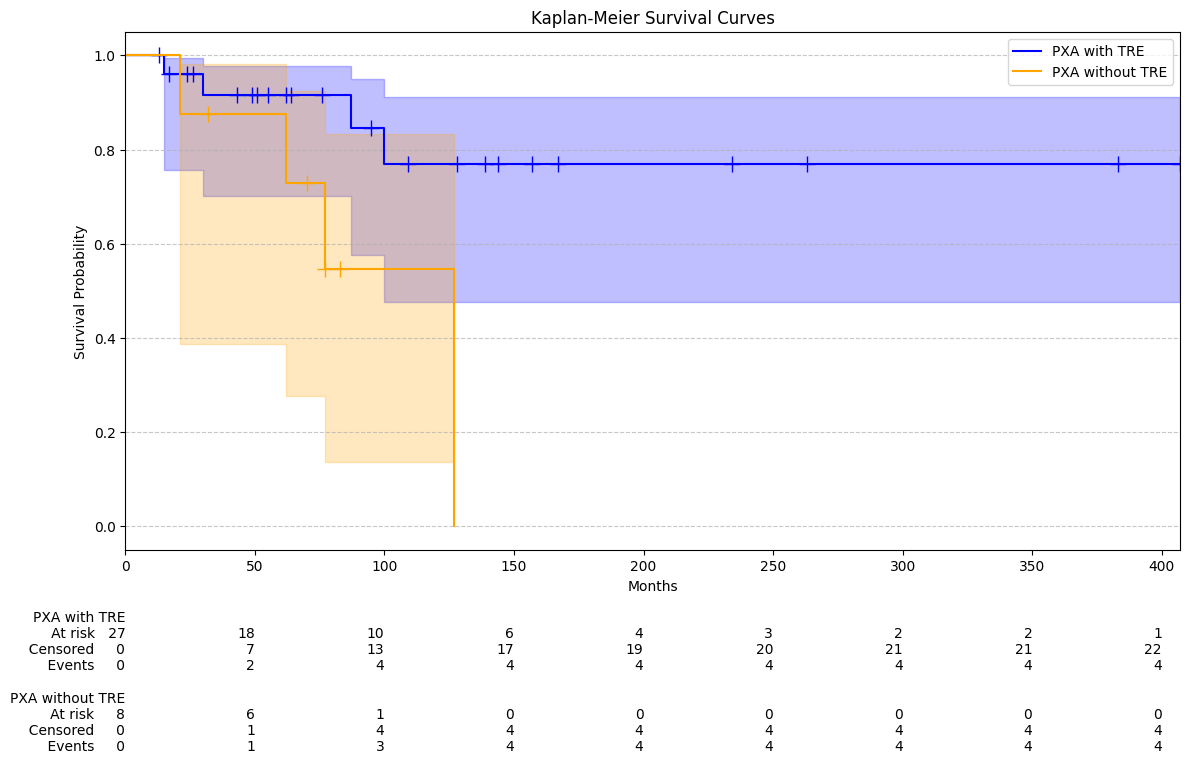

Log-rank test p-value: 0.020500043722310193


In [24]:
# Create Kaplan-Meier fitter instances
kmf_tre = KaplanMeierFitter()
kmf_no_tre = KaplanMeierFitter()

# Fit the data for pxa_tre
kmf_tre.fit(durations=pxa_tre['survival_months'], event_observed=pxa_tre['death'], label='PXA with TRE')

# Fit the data for pxa_no_tre
kmf_no_tre.fit(durations=pxa_no_tre['survival_months'], event_observed=pxa_no_tre['death'], label='PXA without TRE')

# Plot the survival curves with censored patients marked and a survival table
plt.figure(figsize=(12, 8))
ax = kmf_tre.plot_survival_function(show_censors=True, ci_show=True, color='blue', ax=None)
kmf_no_tre.plot_survival_function(show_censors=True, ci_show=True, color='orange', ax=ax)
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves')
plt.xlim(0, 407)  # Expand the x-axis to 407 months
plt.xticks(range(0, 408, 50))  # Set x-ticks to cover up to 407 months with intervals of 50 months
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the survival table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_tre, kmf_no_tre, ax=ax)
plt.tight_layout()
plt.show()

# Perform the log-rank test
results = logrank_test(pxa_tre['survival_months'], pxa_no_tre['survival_months'], event_observed_A=pxa_tre['death'], event_observed_B=pxa_no_tre['death'])
print(f"Log-rank test p-value: {results.p_value}")

### Add multiple comparisons

In [14]:
# Assuming pxa_tre and pxa_no_tre are your DataFrames

# Add a 'group' column to distinguish between the two groups
pxa_tre['group'] = 1  # Seizure-Free group
pxa_no_tre['group'] = 0  # Not Seizure-Free group

# Combine the two DataFrames
pxa = pd.concat([pxa_tre, pxa_no_tre], ignore_index=True)

# Ensure continuous variables are numeric, converting non-numeric values to NaN
continuous_vars = ['presentation_1_age', 'tumor_size']
for var in continuous_vars:
    pxa[var] = pd.to_numeric(pxa[var], errors='coerce')

# Ensure categorical variables are properly formatted
categorical_vars = ['tumor_left', 'sex_female', 'tumor_frontal', 'tumor_temp', 
                    'tumor_parietal', 'tumor_occipital', 'tumor_insula', 'tumor_subcort', 'mut_BRAF_V600E', 
                    'tumor_grade_first_2']

# Convert categorical variables to numeric values
for var in categorical_vars:
    pxa[var] = pd.to_numeric(pxa[var], errors='coerce')

# Function to perform statistical tests for continuous variables
def analyze_continuous_var(var):
    data = pxa.dropna(subset=[var]).copy()
    group1 = data[data['group'] == 1][var]
    group2 = data[data['group'] == 0][var]
    
    # Perform t-test or Mann-Whitney U test
    if np.all(np.isfinite(group1)) and np.all(np.isfinite(group2)):
        t_stat, p_value = ttest_ind(group1, group2)
    else:
        t_stat, p_value = mannwhitneyu(group1, group2)
    
    print(f"Covariate: {var}")
    print(f"Group 1 (Seizure-Free): Mean = {group1.mean()}, Standard Deviation = {group1.std()}")
    print(f"Group 2 (Not Seizure-Free): Mean = {group2.mean()}, Standard Deviation = {group2.std()}")
    print(f"t-test/Mann-Whitney U test for {var}: p-value={p_value}\n")

# Function to perform statistical tests for categorical variables
def analyze_categorical_var(var):
    data = pxa.dropna(subset=[var]).copy()
    
    # Drop rows with 'NR' in the categorical variables
    if var in ['mut_BRAF_V600E', 'tumor_grade_first_2']:
        data = data[data[var] != 'NR']
    
    group1 = data[data['group'] == 1][var]
    group2 = data[data['group'] == 0][var]
    
    # Debugging statements to check the data
    print(f"Analyzing {var}")
    print(f"Group 1 (Seizure-Free): {group1.value_counts()}")
    print(f"Group 2 (Not Seizure-Free): {group2.value_counts()}")
    
    # Calculate the total numbers of 1s and 0s in each group
    total_1_group1 = group1.sum()
    total_0_group1 = len(group1) - total_1_group1
    total_1_group2 = group2.sum()
    total_0_group2 = len(group2) - total_1_group2
    
    # Create the contingency table
    contingency_table = [
        [total_1_group1, total_0_group1],
        [total_1_group2, total_0_group2]
    ]
    
    # Perform Fisher's Exact Test
    _, p_value = fisher_exact(contingency_table)
    
    print(f"Covariate: {var}")
    print(f"Group 1 (Seizure-Free): Total 1s = {total_1_group1}, Proportion 1s = {total_1_group1 / (total_1_group1 + total_0_group1):.2f}")
    print(f"Group 2 (Not Seizure-Free): Total 1s = {total_1_group2}, Proportion 1s = {total_1_group2 / (total_1_group2 + total_0_group2):.2f}")
    print(f"Fisher's Exact Test for {var}: p-value={p_value}\n")

# Analyze continuous variables
for var in continuous_vars:
    analyze_continuous_var(var)

# Analyze categorical variables
for var in categorical_vars:
    if var in pxa.columns:
        analyze_categorical_var(var)
    else:
        print(f"Variable {var} is not present in the dataset and will be skipped.\n")

# Perform multiple comparisons analysis of the log-rank test between the pxa_tre and pxa_no_tre groups
results = logrank_test(pxa_tre['survival_months'], pxa_no_tre['survival_months'], event_observed_A=pxa_tre['death'], event_observed_B=pxa_no_tre['death'])
print(f"Log-rank test p-value: {results.p_value}")

# Fit a Cox proportional hazards model to adjust for covariates
coxph = CoxPHFitter()
# Select relevant columns for the Cox model
cox_columns = ['survival_months', 'death', 'group'] + continuous_vars + categorical_vars
# Drop rows with any NaN values in the selected columns
cox_data = pxa[cox_columns].dropna()

# Fit the Cox model
coxph.fit(cox_data, duration_col='survival_months', event_col='death')

# Print the summary of the Cox model
coxph.print_summary()

# Extract the p-value for the 'group' variable (treatment effect)
adjusted_p_value = coxph.summary.loc['group', 'p']
print(f"Adjusted p-value for survival between pxa_tre and pxa_no_tre: {adjusted_p_value}")

Covariate: presentation_1_age
Group 1 (Seizure-Free): Mean = 22.814814814814813, Standard Deviation = 13.283989892512997
Group 2 (Not Seizure-Free): Mean = 25.75, Standard Deviation = 7.9417522355855805
t-test/Mann-Whitney U test for presentation_1_age: p-value=0.5587881886185271

Covariate: tumor_size
Group 1 (Seizure-Free): Mean = 2.8529411764705883, Standard Deviation = 1.749684845571776
Group 2 (Not Seizure-Free): Mean = 3.6833333333333336, Standard Deviation = 2.54983659607173
t-test/Mann-Whitney U test for tumor_size: p-value=0.3847472183161129

Analyzing tumor_left
Group 1 (Seizure-Free): tumor_left
1    17
0    10
Name: count, dtype: int64
Group 2 (Not Seizure-Free): tumor_left
0    5
1    3
Name: count, dtype: int64
Covariate: tumor_left
Group 1 (Seizure-Free): Total 1s = 17, Proportion 1s = 0.63
Group 2 (Not Seizure-Free): Total 1s = 3, Proportion 1s = 0.38
Fisher's Exact Test for tumor_left: p-value=0.2463595914652644

Analyzing sex_female
Group 1 (Seizure-Free): sex_female


/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/3052537349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_tre['group'] = 1  # Seizure-Free group
/var/folders/wz/rwjf4bd179728l094_dm2yq40000gn/T/ipykernel_68808/3052537349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pxa_no_tre['group'] = 0  # Not Seizure-Free group
/opt/anaconda3/envs/imaging/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently

<lifelines.CoxPHFitter: fitted with 23 total observations, 16 right-censored observations>
             duration col = 'survival_months'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 23
number of events observed = 7
   partial log-likelihood = -1.51
         time fit was run = 2025-03-30 18:26:16 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
group                0.57      1.76     49.83          -97.10           98.24                0.00            4.61e+42
presentation_1_age  -0.52      0.60      1.74           -3.93            2.89                0.02               17.97
tumor_size           1.36      3.90     16.22          -30.42           33.15                0.00            2.49e+14
tumor_left           1.70      5.47     22.20          -41.82           45.22                0.00            4.35e+19
sex_female          -4.01      0.02     22.10          -47.32           39.30                0.00            1.17e+17
tumor_frontal       -2.54      0.08     31.22          -63.73           58.65                0.00            2.95e+25
tumor_temp          14.89  2.93e+06      8.24           -1.26           31.04                0.28            3.02e+13
tumor_parietal      12.67  3.19e+05     25.74          -37.78           63.13                0.00            2.62e+27
tumor_occipital     -4.37      0.01     79.90         -160.97          152.23                0.00            1.29e+66
tumor_insula         9.09   8908.53     32.69          -54.98           73.17                0.00            5.98e+31
tumor_subcort       13.58  7.89e+05     23.78          -33.03           60.18                0.00            1.37e+26
mut_BRAF_V600E       2.05      7.79     12.89          -23.22           27.32                0.00            7.36e+11
tumor_grade_first_2 -5.86      0.00     27.45          -59.66           47.93                0.00            6.56e+20

                     cmp to     z    p  -log2(p)
covariate                                       
group                  0.00  0.01 0.99      0.01
presentation_1_age     0.00 -0.30 0.77      0.39
tumor_size             0.00  0.08 0.93      0.10
tumor_left             0.00  0.08 0.94      0.09
sex_female             0.00 -0.18 0.86      0.22
tumor_frontal          0.00 -0.08 0.94      0.10
tumor_temp             0.00  1.81 0.07      3.82
tumor_parietal         0.00  0.49 0.62      0.68
tumor_occipital        0.00 -0.05 0.96      0.06
tumor_insula           0.00  0.28 0.78      0.36
tumor_subcort          0.00  0.57 0.57      0.82
mut_BRAF_V600E         0.00  0.16 0.87      0.20
tumor_grade_first_2    0.00 -0.21 0.83      0.27
---
Concordance = 1.00
Partial AIC = 29.02
log-likelihood ratio test = 30.11 on 13 df
-log2(p) of ll-ratio test = 7.78

Adjusted p-value for survival between pxa_tre and pxa_no_tre: 0.9909361612582914


In [16]:
import pandas as pd

# Assuming the Cox model has already been fitted as `coxph`

# Extract the relevant columns from the Cox model summary
cox_summary = coxph.summary
cox_summary['Hazard Ratio'] = cox_summary['exp(coef)']
cox_summary['95% CI'] = cox_summary.apply(
    lambda row: f"{row['exp(coef) lower 95%']:.2f} - {row['exp(coef) upper 95%']:.2f}", axis=1
)
cox_summary['p-value'] = cox_summary['p']

# Create the modified table
modified_table = cox_summary[['Hazard Ratio', '95% CI', 'p-value']].reset_index()
modified_table.rename(columns={'index': 'Variable'}, inplace=True)

# Print the modified table
print(modified_table)

              covariate  Hazard Ratio  \
0                 group  1.761390e+00   
1    presentation_1_age  5.952174e-01   
2            tumor_size  3.901994e+00   
3            tumor_left  5.474891e+00   
4            sex_female  1.813100e-02   
5         tumor_frontal  7.890852e-02   
6            tumor_temp  2.925725e+06   
7        tumor_parietal  3.192999e+05   
8       tumor_occipital  1.265891e-02   
9          tumor_insula  8.908533e+03   
10        tumor_subcort  7.891290e+05   
11       mut_BRAF_V600E  7.789319e+00   
12  tumor_grade_first_2  2.840901e-03   

                                               95% CI   p-value  
0   0.00 - 460803787839748295066478286330531309158...  0.990936  
1                                        0.02 - 17.97  0.765398  
2                           0.00 - 248768174387623.41  0.933096  
3                      0.00 - 43543212405813387264.00  0.938967  
4                        0.00 - 117303267669762256.00  0.856006  
5                0.00 - 29526

### Tumor-directed therapy and survival

In [19]:
from lifelines import CoxPHFitter

# Function to calculate hazard ratio and p-value using Cox proportional hazards model
def cox_analysis(data, variable):
    # Prepare the data for the Cox model
    cox_data = data[['survival_months', 'death', variable]].dropna()
    
    # Fit the Cox model
    coxph = CoxPHFitter()
    coxph.fit(cox_data, duration_col='survival_months', event_col='death')
    
    # Extract the hazard ratio and p-value
    hazard_ratio = coxph.summary.loc[variable, 'exp(coef)']
    p_value = coxph.summary.loc[variable, 'p']
    
    # Print the results
    print(f"Variable: {variable}")
    print(f"Hazard Ratio: {hazard_ratio:.2f}")
    print(f"p-value: {p_value:.4f}\n")

# Analyze survival for tmz_initial, tmz_any, braf_initial, and braf_any
variables_to_analyze = ['tmz_initial', 'tmz_any', 'braf_initial', 'braf_any']
for var in variables_to_analyze:
    cox_analysis(pxa, var)

Variable: tmz_initial
Hazard Ratio: 2.18
p-value: 0.2715

Variable: tmz_any
Hazard Ratio: 7.78
p-value: 0.0557

Variable: braf_initial
Hazard Ratio: 0.00
p-value: 0.9965

Variable: braf_any
Hazard Ratio: 2.95
p-value: 0.1682



/opt/anaconda3/envs/imaging/lib/python3.12/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column braf_initial have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['death'].astype(bool)
>>> print(df.loc[events, 'braf_initial'].var())
>>> print(df.loc[~events, 'braf_initial'].var())

A very low variance means that the column braf_initial completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/anaconda3/envs/imaging/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1607: ConvergenceWarning: Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.236. This may imply non-unique solutions to the maximum likelihood. Per

In [20]:
# Function to calculate mean, standard deviation, and p-value for survival months
def analyze_survival_by_tre(data_tre, data_no_tre, variable):
    # Filter data for the variable
    tre_with_var = data_tre[data_tre[variable] == 1]
    tre_without_var = data_tre[data_tre[variable] == 0]
    no_tre_with_var = data_no_tre[data_no_tre[variable] == 1]
    no_tre_without_var = data_no_tre[data_no_tre[variable] == 0]
    
    # Calculate mean and standard deviation for survival months
    mean_tre_with_var = tre_with_var['survival_months'].mean()
    std_tre_with_var = tre_with_var['survival_months'].std()
    mean_tre_without_var = tre_without_var['survival_months'].mean()
    std_tre_without_var = tre_without_var['survival_months'].std()
    mean_no_tre_with_var = no_tre_with_var['survival_months'].mean()
    std_no_tre_with_var = no_tre_with_var['survival_months'].std()
    mean_no_tre_without_var = no_tre_without_var['survival_months'].mean()
    std_no_tre_without_var = no_tre_without_var['survival_months'].std()
    
    # Perform t-tests
    t_stat_tre, p_value_tre = ttest_ind(tre_with_var['survival_months'], tre_without_var['survival_months'], nan_policy='omit')
    t_stat_no_tre, p_value_no_tre = ttest_ind(no_tre_with_var['survival_months'], no_tre_without_var['survival_months'], nan_policy='omit')
    
    # Print results
    print(f"Variable: {variable}")
    print(f"With TRE and {variable}: Mean = {mean_tre_with_var:.2f} months, SD = {std_tre_with_var:.2f} months")
    print(f"With TRE and no {variable}: Mean = {mean_tre_without_var:.2f} months, SD = {std_tre_without_var:.2f} months")
    print(f"t-test p-value (TRE): {p_value_tre:.4f}")
    print(f"Without TRE and {variable}: Mean = {mean_no_tre_with_var:.2f} months, SD = {std_no_tre_with_var:.2f} months")
    print(f"Without TRE and no {variable}: Mean = {mean_no_tre_without_var:.2f} months, SD = {std_no_tre_without_var:.2f} months")
    print(f"t-test p-value (No TRE): {p_value_no_tre:.4f}\n")

# Analyze survival for tmz_any and braf_any
variables_to_analyze = ['tmz_any', 'braf_any']
for var in variables_to_analyze:
    analyze_survival_by_tre(pxa_tre, pxa_no_tre, var)

Variable: tmz_any
With TRE and tmz_any: Mean = 89.45 months, SD = 70.87 months
With TRE and no tmz_any: Mean = 123.75 months, SD = 123.17 months
t-test p-value (TRE): 0.4140
Without TRE and tmz_any: Mean = 67.43 months, SD = 34.95 months
Without TRE and no tmz_any: Mean = 77.00 months, SD = nan months
t-test p-value (No TRE): 0.8064

Variable: braf_any
With TRE and braf_any: Mean = 58.88 months, SD = 28.80 months
With TRE and no braf_any: Mean = 131.21 months, SD = 117.89 months
t-test p-value (TRE): 0.1023
Without TRE and braf_any: Mean = 83.00 months, SD = nan months
Without TRE and no braf_any: Mean = 66.57 months, SD = 34.58 months
t-test p-value (No TRE): 0.6723

